# 2.	Please analyze the signal’s effectiveness or lack thereof in forecasting ETF price, using whatever metrics you think are most relevant.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib as mpl
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
pd.options.mode.chained_assignment = None

In [2]:
iwm = pd.read_csv('IWM 19Nov2015-06Jan2020.csv')
iwm = iwm.set_index(['Date'])
signal = pd.read_csv('Sample Dataset_corrected.csv')
signal = signal.set_index(['Date'])

In [3]:
data = pd.concat([signal['Signal'],iwm.loc[:,'Open':'Adj Close']],axis = 1)
data.head()

,Signal,Open,High,Low,Close,Adj Close
Date,,,,,,
2015-11-19,13.768540,116.440002,116.650002,115.739998,116.059998,107.580505
2015-11-20,13.608819,116.480003,117.360001,116.379997,116.809998,108.275726
2015-11-23,12.990589,116.709999,117.889999,116.680000,117.389999,108.813324
2015-11-24,12.667435,116.879997,118.419998,116.559998,118.250000,109.610512
2015-11-25,13.019910,118.300003,119.320000,118.110001,119.169998,110.463310


Remove outliers

In [4]:
rem_index = list(data[data['Signal']==0].index)
rem_index += list(data[data['Signal']>30].index)
rem_index

['2018-11-12',
 '2018-11-13',
 '2018-11-14',
 '2018-11-15',
 '2018-11-16',
 '2019-12-27',
 '2019-12-30',
 '2019-12-31',
 '2020-01-02',
 '2020-01-03',
 '2020-01-06',
 '2017-11-13']

In [5]:
data = data.drop(index = rem_index)

# correlation

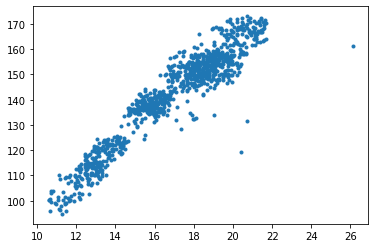

In [6]:
plt.plot(data['Signal'],data['Close'],'.')

In [7]:
np.corrcoef(data['Signal'],data['Close'])

array([[1.       , 0.9497295],
       [0.9497295, 1.       ]])

np.corrcoef(np.diff(np.log(np.array(data['Signal']))),np.diff(np.log(np.array(data['Close']))))

So signal is highly correlated to the price instead of the return.

# For prediction accuracy, assuming same day prediction

## OLS Regression, y = Close, x = Signal

Model: y = Intercept + Beta * x

In [8]:
x = np.array(data['Signal']).reshape(-1,1)
y = np.array(data['Close'])

First split the dataset to a training set and testing set to avoid overfitting

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size=0.3, 
                                                    random_state=1000)

In [10]:
reg = linear_model.LinearRegression()
reg.fit(x_train,y_train)
print("Training score: {0:.4f}".format(reg.score(x_train,y_train)))
print("Testing score: {0:.4f}".format(reg.score(x_test,y_test)))

Training score: 0.9037
Testing score: 0.8965


Then using ross validation with 5 folds to get average score for model selection

In [11]:
lin_scores = cross_val_score(reg, x_train,y_train,cv=5)
print("CV scores: {}".format(lin_scores))
print("CV mean score: {0:.4f}".format(np.mean(lin_scores)))

CV scores: [0.93345947 0.86396863 0.93366493 0.86284979 0.90840444]
CV mean score: 0.9005


Prediction accuracy for direction

In [12]:
y_pred = reg.predict(x)
same_dir = np.where(np.multiply(np.diff(y_pred),np.diff(y))>0,1,0)
print("Percentage of accurate predictions: {0:.4%}".format(\
        sum(same_dir)/(len(y_pred)-1)))

Percentage of accurate predictions: 47.4146%


Mean absolute error and Mean squared error

In [13]:
print("MAE: {0:.4f}, MSE: {1:.4f}".format(np.mean(np.abs(y_pred - y))
                                          ,np.mean((y_pred - y)**2)))

MAE: 4.3113, MSE: 33.1447


Complied in function to evaluate more models:

In [14]:
def reg_model(x,y):
    res = []
    x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                        test_size=0.3, 
                                                        random_state=11)
    reg = linear_model.LinearRegression()
    reg.fit(x_train,y_train)
    #training score
    res.append(reg.score(x_train,y_train))
    #cross validation score
    lin_scores = cross_val_score(reg, x_train,y_train,cv=5)
    res.append(np.mean(lin_scores))
    #test score
    res.append(reg.score(x_test,y_test))
    #prediction accuracy for direction
    y_pred = reg.predict(x)
    same_dir = np.where(np.diff(y_pred)>0,1,0) == np.where(np.diff(y)>0,1,0)
    res.append(sum(same_dir)/(len(y_pred)-1))
    #Mean Abs error
    res.append(np.mean(np.abs(y_pred - y)))
    #Mean squared error
    res.append(np.mean((y_pred - y)**2))
    
    return res

In [15]:
res = pd.DataFrame(index = ['Training Score','Cross Val Score',
                            'Test Score', 'Pred Dir Accuracy',
                            'MAE','MSE'])

In [16]:
res['OLS'] = reg_model(x,y)
res

,OLS
Training Score,0.899328
Cross Val Score,0.897022
Test Score,0.908022
Pred Dir Accuracy,0.475122
MAE,4.313130
MSE,33.134756


## polynomial regression

Second order: y = Intercept + Beta1 * x + Beta2 * x^2

In [17]:
x_poly_2 = np.concatenate((x,x**2),axis=1)
res['OLS-Poly2'] = reg_model(x_poly_2,y) 

Thrid order: y = Intercept + Beta1 * x + Beta2 * x^2 + Beta3 * x^3

In [18]:
x_poly_3 = np.concatenate((x,x**2,x**3),axis=1)
res['OLS-Poly3'] = reg_model(x_poly_3,y)

## Signal and Open - last day Close for intraday prediction

Model: y = Intercept + Beta1 * x + Beta2 * [Open at (T) day - Close at (T-1) day]

In [19]:
xo = np.concatenate((np.array(data['Signal'])[1:].reshape(-1,1),
                     (np.array(data['Open'][1:])\
                      - np.array(data['Close'][:-1])).reshape(-1,1)),
                    axis = 1)
yo = np.array(data['Close'])[1:]

In [20]:
res['Sig,Open-Close']=reg_model(xo,yo)

In [21]:
res

,OLS,OLS-Poly2,OLS-Poly3,"Sig,Open-Close"
Training Score,0.899328,0.917690,0.917987,0.898230
Cross Val Score,0.897022,0.914870,0.913681,0.894660
Test Score,0.908022,0.923147,0.922986,0.909578
Pred Dir Accuracy,0.475122,0.475122,0.475122,0.473633
MAE,4.313130,3.962962,3.960450,4.323924
MSE,33.134756,27.255578,27.200902,33.185884


## Time Series model

For prices data, it worth to try time series model, first step is to stationize the data by take first order difference of it:

In [22]:
df = np.diff(data['Close'])

Then run unit root test to test for stationarity

In [23]:
result = adfuller(df)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -32.110516
p-value: 0.000000
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568


The statistic is very small compared to the different level of critical values, so can say that **the difference of "Close" is stationary.**

Then is to determine how many lags to included in the model, using acf (auto-correlation function) plot and pacf (partial auto-correlation function) plot:

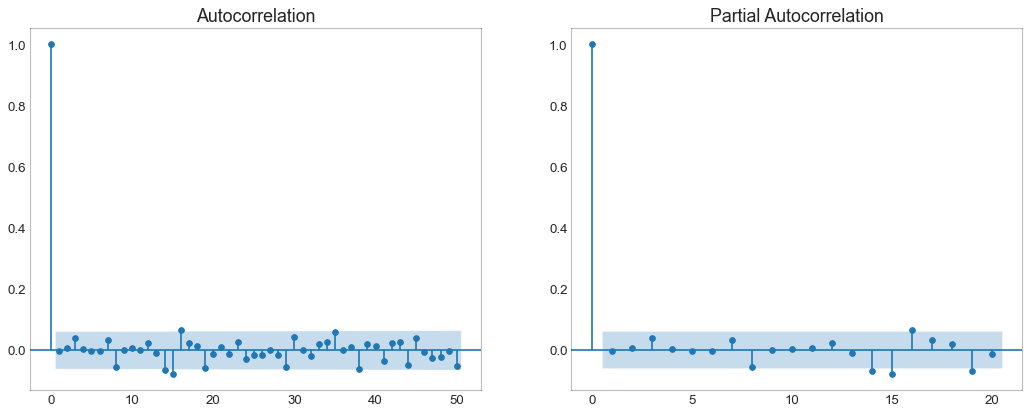

In [24]:
large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,6), dpi= 80)
plot_acf(df, ax=ax1, lags=50)
plot_pacf(df, ax=ax2, lags=20)


ax1.spines["top"].set_alpha(.3); ax2.spines["top"].set_alpha(.3)
ax1.spines["bottom"].set_alpha(.3); ax2.spines["bottom"].set_alpha(.3)
ax1.spines["right"].set_alpha(.3); ax2.spines["right"].set_alpha(.3)
ax1.spines["left"].set_alpha(.3); ax2.spines["left"].set_alpha(.3)


ax1.tick_params(axis='both', labelsize=12)
ax2.tick_params(axis='both', labelsize=12)
plt.show()

From the graphs, it is suggested that no lags are significant for "Close". But I still try 3 different models

1. Close(T) = Intercept + Signal(T) + Signal(T-1) + Close(T-1)

In [25]:
y = np.array(data['Close'])[1:]
x1 = np.array(data['Signal'])[1:].reshape(-1,1)
x2 = np.array(data['Signal'])[:-1].reshape(-1,1)
x3 = np.array(data['Close'])[:-1].reshape(-1,1)
x = np.concatenate((x1,x2,x3),axis=1)

res['TS(T-1)']=reg_model(x,y)

2. Close(T) = Intercept + Signal(T) + Signal(T-1) + Signal(T-2) + Close(T-1) + Close(T-2)

In [26]:
y = np.array(data['Close'])[2:]
x1 = np.array(data['Signal'])[2:].reshape(-1,1)
x2 = np.array(data['Signal'])[1:-1].reshape(-1,1)
x3 = np.array(data['Signal'])[:-2].reshape(-1,1)
x4 = np.array(data['Close'])[1:-1].reshape(-1,1)
x5 = np.array(data['Close'])[:-2].reshape(-1,1)
x = np.concatenate((x1,x2,x3,x4,x5),axis=1)

res['TS(T-2)']=reg_model(x,y)

3. Close(T) = Intercept + Signal(T) + Signal(T-1) + [Close(T-1) - Close(T-2)]

In [27]:
y = np.array(data['Close'])[2:]
x1 = np.array(data['Signal'])[2:].reshape(-1,1)
x2 = np.array(data['Signal'])[1:-1].reshape(-1,1)
x3 = np.array(data['Close'])[1:-1].reshape(-1,1)-np.array(data['Signal'])[:-2].reshape(-1,1)
x = np.concatenate((x1,x2,x3),axis=1)

res['TS(T-2)*']=reg_model(x,y)

# Comparison of the results

In [28]:
res

,OLS,OLS-Poly2,OLS-Poly3,"Sig,Open-Close",TS(T-1),TS(T-2),TS(T-2)*
Training Score,0.899328,0.917690,0.917987,0.898230,0.994377,0.994621,0.992270
Cross Val Score,0.897022,0.914870,0.913681,0.894660,0.994201,0.994461,0.991959
Test Score,0.908022,0.923147,0.922986,0.909578,0.994117,0.993730,0.991036
Pred Dir Accuracy,0.475122,0.475122,0.475122,0.473633,0.485352,0.478006,0.477028
MAE,4.313130,3.962962,3.960450,4.323924,1.039149,1.036317,1.248715
MSE,33.134756,27.255578,27.200902,33.185884,1.923234,1.896165,2.720528


Including lag 1 price improve the prediction accuracy by a lot, indicated by the increased scores (R^2 socre) and reduced MAE and MSE.

# Conclusion

**Effectiveness:**

1. The Signal can give a pretty good estimation of the price level for some models  
2. Only one column of Signal is given which speed up the decision making process so that we don't need to look at many metrics but one single series

**Lack:**

1. The signal performs poorly in estimating the direction of the prices changes, lower than 50% for the models I chooses (maybe other model can do better), but without more information, it is even worse than tossing a coin.
2. Signals for some days at the end of the datasets are zeros, which is quite an issue as it is the unique product of the company, we can download market data from public source, but are paying for the "Signals".